System Rekomendasi Buku menggunakan Collaborative Filtering - Risky Novendri

# Load Dataset

Download dataset dari kaggle dan pindahkan ke dalam Google drive

In [ ]:
#Set kaggle API
import os
os.environ['KAGGLE_USERNAME'] = "riskynovendri"
os.environ['KAGGLE_KEY'] = "dd57766230ed28e08a6bbed6903c7745"

In [ ]:
#Download dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

In [ ]:
#Move to Gdrive
!mv /content/book-recommendation-dataset.zip /content/drive/MyDrive/

In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/book-recommendation-dataset.zip'

In [ ]:
## Extract Dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/MLT Submission 2 Dataset')

Import library yang dibutuhkan untuk membangun sistem rekomendasi

In [ ]:
#Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow import keras

Load semua dataset yang ada yaitu User, Rating dan Books

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/MLT Submission 2 Dataset/Users.csv')

In [ ]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
rating = pd.read_csv('/content/drive/MyDrive/MLT Submission 2 Dataset/Ratings.csv')

In [ ]:
book = pd.read_csv('/content/drive/MyDrive/MLT Submission 2 Dataset/Books.csv')

<ipython-input-13-c4b427baf1e0>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv('/content/drive/MyDrive/MLT Submission 2 Dataset/Books.csv')


In [ ]:
rating

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
book

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


# Data Understanding

Mengecek Kondisi dataset yang dimiliki

In [ ]:
# Cek jumlah unique dataset
print("Jumlah Unique {} dari {} pada data users".format(len(users['User-ID'].unique()),len(users['User-ID'])))
print("Jumlah Unique {} dari {} pada data rating".format(len(rating['User-ID'].unique()),len(rating['User-ID'])))
print("Jumlah Unique {} dari {} pada data rating".format(len(rating['ISBN'].unique()),len(rating['ISBN'])))
print("Jumlah Unique {} dari {} pada data book".format(len(book['ISBN'].unique()),len(book['ISBN'])))
print(max(rating['User-ID']))
print(min(rating['User-ID']))
print(max(rating['Book-Rating']))
print(min(rating['Book-Rating']))

Jumlah Unique 278858 dari 278858 pada data users
Jumlah Unique 105283 dari 1149780 pada data rating
Jumlah Unique 340556 dari 1149780 pada data rating
Jumlah Unique 271360 dari 271360 pada data book
278854
2
10
0


Mengecek informasi tipe data dan kolom yang ada

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
rating.rename(columns={"User-ID" : "user_id", "Book-Rating" : "book_rating"}, inplace=True)

<Axes: >

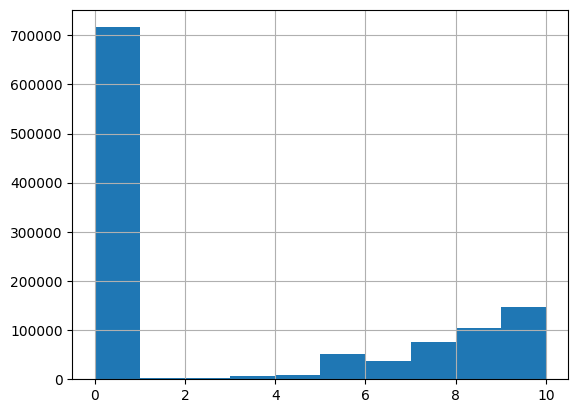

In [ ]:
rating['book_rating'].hist()

Persebaran data pada book rating terlalu banyak yang 0 dengan asumsi user tidak atau belum memberikan rating pada buku tersebut. Untuk data rating 0 dianggap tidak memiliki makna apapun maka buku dengan rating 0 akan di hapus

EDA data rating

In [ ]:
rating.describe()

,user_id,book_rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [ ]:
rating_clean = rating[rating['book_rating'] > 0].sort_values('user_id', ascending=True)

<Axes: >

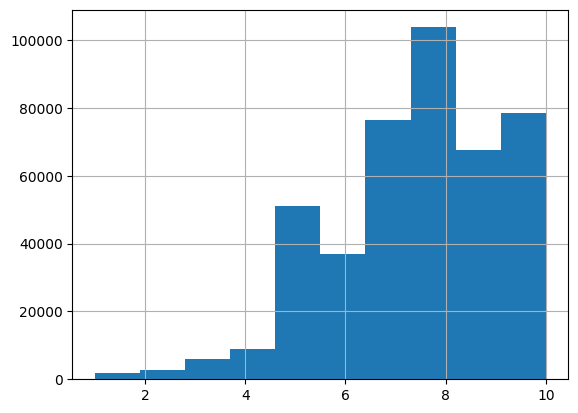

In [ ]:
rating_clean['book_rating'].hist()

Distribusi pada data terlihat condong ke kiri dimana banyak user yang memberikan rating tinggi

In [ ]:
rating_clean.describe()

,user_id,book_rating
count,433671.000000,433671.000000
mean,135458.743451,7.601066
std,80678.385078,1.843798
min,8.000000,1.000000
25%,66619.000000,7.000000
50%,133184.000000,8.000000
75%,205735.000000,9.000000
max,278854.000000,10.000000


Hasil statistik terlihat lebih baik setelah di cleansing

In [ ]:
df = rating_clean.sample(n=20000, random_state=42)

Batasi dataset karena masalah keterbatasan resources google colab yang tidak mampu mengolah lebih banyak data

# Data Preparation

Transformasi data yang diperlukan untuk Collaborative fitering dan Conten Based Filtering

In [ ]:
#collaborative filtering
user_item_matrix = df.pivot_table(index='user_id', columns='ISBN', values='book_rating').fillna(0)

Encode atribut ISBN dan User ID

In [ ]:
# Mengubah ISBN menjadi list tanpa nilai yang sama
books_ids = df['ISBN'].unique().tolist()

# Melakukan proses encoding ISBN
books_to_books_encoded = {x: i for i, x in enumerate(books_ids)}

# Melakukan proses encoding angka ke ISBN
books_encoded_to_books = {i: x for i, x in enumerate(books_ids)}

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['user_id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

list userID:  [188171, 95359, 132173, 216955, 6575, 63714, 129074, 26583, 93047, 205114, 244487, 4766, 193778, 198727, 225595, 55490, 231237, 98686, 94853, 11676, 242118, 240144, 131545, 7860, 185233, 272273, 136014, 145449, 114988, 117985, 208704, 208719, 121170, 26240, 144654, 6873, 123825, 225087, 229011, 274061, 242409, 137397, 91058, 128085, 36836, 5774, 134413, 136139, 252510, 185683, 20719, 185011, 153662, 38767, 224997, 148258, 187397, 232171, 88620, 208468, 4570, 196738, 56469, 162473, 52350, 193458, 123981, 3363, 21014, 194287, 205962, 193777, 244833, 166596, 39467, 263877, 88187, 166123, 48355, 93245, 256925, 152099, 115081, 135149, 34987, 266820, 2313, 125583, 88733, 85656, 207246, 183046, 45074, 107784, 185528, 238781, 135869, 217318, 260473, 210506, 242943, 54335, 182642, 278194, 165669, 136905, 23902, 203240, 128835, 84024, 228154, 189835, 66470, 163973, 23714, 114544, 13552, 45315, 176481, 124876, 201058, 237433, 79950, 185538, 3791, 231263, 33933, 111851, 86243, 165345

In [ ]:
# Mapping user ke dataframe df
df['user'] = df['user_id'].map(user_to_user_encoded)

# Mapping ISBN ke dataframe df
df['isbn'] = df['ISBN'].map(books_to_books_encoded)

# Content Based Filtering

Load Dataset

In [ ]:
# Membuat Dataframe Book
df_books = book[['ISBN','Book-Title','Book-Author']]
df_books.rename(columns={"Book-Title" : "book_title", "Book-Author" : "book_author"}, inplace=True)

<ipython-input-111-c2eaa7ad3a43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books.rename(columns={"Book-Title" : "book_title", "Book-Author" : "book_author"}, inplace=True)


In [ ]:
df_books

,ISBN,book_title,book_author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger
271356,0525447644,From One to One Hundred,Teri Sloat
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271358,0192126040,Republic (World's Classics),Plato


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Data Preparation

Pada data terdapat beberapa nilai null sehingga perlu di bersihkan

In [ ]:
df_books.isnull().sum() #Cek data null

ISBN           0
book_title     0
book_author    1
dtype: int64

In [ ]:
df_books.dropna(inplace=True) #Drop Null

<ipython-input-116-dc473bcc2111>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books.dropna(inplace=True)


In [ ]:
df_books.isnull().sum()#Cek kembali nilai null

ISBN           0
book_title     0
book_author    0
dtype: int64

Melakukan drop duplicates untuk menghindari duplikasi data

In [ ]:
df_books.drop_duplicates(subset='book_title',inplace =True) #Drop judul buku yang duplicate

<ipython-input-118-61e9acbc758b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books.drop_duplicates(subset='book_title',inplace =True)


In [ ]:
#Cek Unique author
print(len(df_books))
print(len(df_books['book_author'].unique()))

242134
99685


In [ ]:
df_books[df_books['book_author'].str.contains('Koontz', case=False)]['book_author'].unique() #Cek author nama koontz

array(['Dean R. Koontz', 'Dean Koontz', 'DEAN KOONTZ',
       'Dean R. (Dean Rae) Koontz', 'Dean R Koontz', 'Ted Koontz'],
      dtype=object)

Author bernama koontz memiliki nama yang tidak konsisten sehigga di hitung unique berbeda

In [ ]:
#Membuat author jadi konsisten
df_books = df_books.replace('Dean Koontz', 'Dean R. Koontz')
df_books = df_books.replace('DEAN KOONTZ', 'Dean R. Koontz')
df_books = df_books.replace('Dean R. (Dean Rae) Koontz', 'Dean R. Koontz')
df_books = df_books.replace('Dean R Koontz', 'Dean R. Koontz')

In [ ]:
df_books[df_books['book_author'].str.contains('Koontz', case=False)]['book_author'].unique() # Cek kembali

array(['Dean R. Koontz', 'Ted Koontz'], dtype=object)

In [ ]:
df_books = df_books.sample(n=20000, random_state=42) # Ambil sample random dikarenakan keterbatasan resources

Melakukan perhitungan TF-IDF untuk dapat menghitung cosine similiarity

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data books
tf.fit(df_books['book_author'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['60623', '86', 'aa', ..., 'â¼rrenmatt', 'â¼ssmuth', 'â¼ter'],
      dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
book_features_tfidf = tf.fit_transform(df_books['book_author'])

# Melihat ukuran matrix tfidf
book_features_tfidf.shape

(20000, 11746)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Kalkulasi pairwise cosine similarity dengan book_author
cosine_similarities = cosine_similarity(book_features_tfidf)

In [ ]:
# Membuat dataframe dari variabel cosine_similarities dengan baris dan kolom berupa nama buku
cosine_sim_df = pd.DataFrame(cosine_similarities, index=df_books['book_title'], columns=df_books['book_title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (20000, 20000)


book_title,I Just Kept Hoping,Seasons of the Heart (Destiny),Stuart Little Search and Find,Lebensansichten Des Katers Murr,Profit from the Power of Many: How to Use MasterMind Teams to Create Success
book_title,,,,,
Ring of Bright Water,0.0,0.0,0.0,0.0,0.0
Winter Kills.,0.0,0.0,0.0,0.0,0.0
Best Friend Insurance,0.0,0.0,0.0,0.0,0.0
The Virgin of Bennington,0.0,0.0,0.0,0.0,0.0
No Safe Place,0.0,0.0,0.0,0.0,0.0
"Smokehouse Ham, Spoon Bread, &amp; Scuppernong Wine: The Folklore and Art of Southern Appalachian Cooking",0.0,0.0,0.0,0.0,0.0
"HOW TO STOP WORRYING, REVISED",0.0,0.0,0.0,0.0,0.0
"Flash, Crash, Rumble, and Roll (Lets Read and Find Out)",0.0,0.0,0.0,0.0,0.0
Compass American Guides : Idaho,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Merge the dataframes based on the "ISBN" column
merged_data = pd.merge(rating_clean, df_books, on="ISBN", how="inner")

# Display the merged dataframe
merged_data

,user_id,ISBN,book_rating,book_title,book_author
0,8,0887841740,5,The Middle Stories,Sheila Heti
1,39,0553582909,8,Icebound,Dean R. Koontz
2,41455,0553582909,4,Icebound,Dean R. Koontz
3,47316,0553582909,9,Icebound,Dean R. Koontz
4,78973,0553582909,6,Icebound,Dean R. Koontz
...,...,...,...,...,...
28276,278543,1576734218,5,On Becoming Childwise,Gary Ezzo
28277,278582,0141001976,8,Blanche Passes Go,Barbara Neely
28278,278668,8423322912,5,La Perla del Oriente (ColecciÃ³n Ancora y delf...,Jorge Ordaz
28279,278843,0689818904,7,My Grandmother's Journey,John Cech


In [ ]:
data = merged_data[['user_id','book_rating','book_author','book_title']]

In [ ]:
data

,user_id,book_rating,book_author,book_title
0,8,5,Sheila Heti,The Middle Stories
1,39,8,Dean R. Koontz,Icebound
2,41455,4,Dean R. Koontz,Icebound
3,47316,9,Dean R. Koontz,Icebound
4,78973,6,Dean R. Koontz,Icebound
...,...,...,...,...
28276,278543,5,Gary Ezzo,On Becoming Childwise
28277,278582,8,Barbara Neely,Blanche Passes Go
28278,278668,5,Jorge Ordaz,La Perla del Oriente (ColecciÃ³n Ancora y delf...
28279,278843,7,John Cech,My Grandmother's Journey


In [ ]:
user_profile = data[data['user_id']== 39] # Ambil sample user profile dengan id 39

In [ ]:
# user_profile = user_profile[['book_title']] #ambil judul buku

In [ ]:
# book_indices

Membuat fungsi untuk dapat memberikan rekomendasi dari hasil perhitungan Cosine Similiarity

In [ ]:
def book_recommendations(judul_buku, similarity_data=cosine_sim_df, items=df_books[['book_title','book_author']], k=5):
    # Mengambil data dengan menggunakan argpartition
    index = similarity_data.loc[:,judul_buku].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop judul_buku agar judul buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_buku, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Melakukan test rekomendasi pada model

In [ ]:
user_profile['book_title'].head(1).item() # cek judul buku yang dimiliki user

'Icebound'

In [ ]:
user_profile.head(1)

,user_id,book_rating,book_author,book_title
1,39,8,Dean R. Koontz,Icebound


In [ ]:
book_recommendations(user_profile['book_title'].head(1).item()) #test rekomendasi

,book_title,book_author
0,The Funhouse,Dean R. Koontz
1,Morgengrauen. Sonderausgabe.,Dean R. Koontz
2,The Mask,Dean R. Koontz
3,Mask,Dean R. Koontz
4,Unico Superviviente,Dean R. Koontz


# Modelling Using Collaborative Filtering

Memulai untuk menghitung dan menerapkan SVD

In [ ]:
user_item_matrix

ISBN,0330299891,0+399139745,0.15.602732.1,00000000,0000000051,000104799X,000171306X,0001846434,0001900277,0001938134,...,B00006JO2X,B0000AZW79,B0000DNSQL,ISBN159105080,NA4221971,O553275380,O688097480,O812579453,X000000000,"\0432534220\"""""
user_id,,,,,,,,,,,,,,,,,,,,,
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_item_matrix = user_item_matrix.values  # Convert to NumPy array

In [ ]:
# Apply Singular Value Decomposition (SVD)
U, sigma, Vt = svds(user_item_matrix, k=20)

In [ ]:
# Convert sigma kedalam bentuk diagonal matrix
sigma_diag_matrix = np.diag(sigma)

# Rekonstruksi ratings matrix
predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)

Membuat Layer Model sesuai dengan kebutuhan

In [ ]:
# Step 3: Deep Learning Model
embedding_dim = 100  # Adjust as desired

# Define input layer
input_layer = Input(shape=(2,), name='input')

# Embedding layers
embedding = Embedding(input_dim=user_item_matrix.shape[0] + user_item_matrix.shape[1], output_dim=embedding_dim,embeddings_initializer = 'he_normal',embeddings_regularizer = keras.regularizers.l2(1e-6))(input_layer)
flatten = Flatten()(embedding)

# # Concatenate embeddings
# concat = concatenate([user_embedding, book_embedding])
# flatten = Flatten()(concat)

# Dense layers
# Dense layers
dense1 = Dense(64, activation='relu')(flatten)
dense2 = Dense(32, activation='relu')(dense1)
dropout1 = Dropout(0.3)(dense2)
dense3 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.4)(dense3)
dense4 = Dense(128, activation='relu')(dropout2)
dense5 = Dense(32, activation='relu')(dense4)
output = Dense(1, activation='linear')(dense5)

# Define the model
model = Model(inputs=input_layer, outputs=output)
model.compile(loss = tf.keras.losses.Huber(),
    optimizer = Adam(learning_rate=0.00001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 embedding (Embedding)       (None, 2, 100)            2692800   
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               8448  

Membagi dataset training dan testing

In [ ]:
X = df[['user','isbn']].values
y = df['book_rating'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define a callback to save the model with the lowest validation loss (MSE)
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
History = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[checkpoint_callback])

Epoch 1/100
500/500 [==============================] - 28s 52ms/step - loss: 7.0271 - root_mean_squared_error: 7.7409 - val_loss: 6.8815 - val_root_mean_squared_error: 7.6074
Epoch 2/100
500/500 [==============================] - 27s 54ms/step - loss: 6.3635 - root_mean_squared_error: 7.1088 - val_loss: 5.5188 - val_root_mean_squared_error: 6.2923
Epoch 3/100
500/500 [==============================] - 28s 57ms/step - loss: 3.4427 - root_mean_squared_error: 4.4701 - val_loss: 1.3938 - val_root_mean_squared_error: 2.1758
Epoch 4/100
500/500 [==============================] - 23s 47ms/step - loss: 1.2232 - root_mean_squared_error: 2.0471 - val_loss: 1.0889 - val_root_mean_squared_error: 1.8571
Epoch 5/100
500/500 [==============================] - 25s 50ms/step - loss: 1.1382 - root_mean_squared_error: 1.9566 - val_loss: 1.0632 - val_root_mean_squared_error: 1.8303
Epoch 6/100
500/500 [==============================] - 32s 64ms/step - loss: 1.0914 - root_mean_squared_error: 1.8938 - val_l

# Evaluation

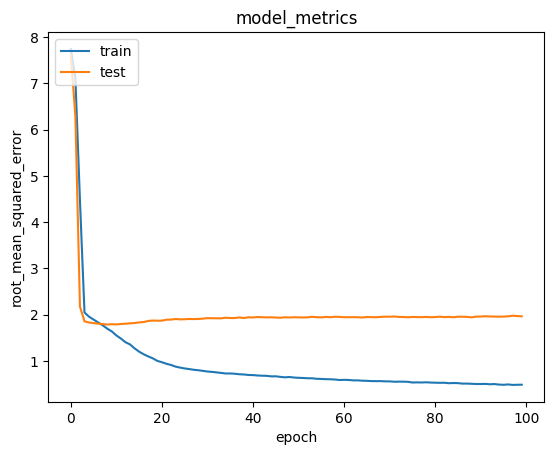

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history['root_mean_squared_error'])
plt.plot(History.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Selama proses learning performa model semakin membaik dan juga RMSE yang dihasilkan juga sangat kecil

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate the best model
loss, rmse = best_model.evaluate(X_val, y_val)
print('Loss:', loss)
print('RMSE:', rmse)

125/125 [==============================] - 1s 7ms/step - loss: 1.0179 - root_mean_squared_error: 1.7901
Loss: 1.017869234085083
RMSE: 1.7900846004486084


Melakukan testing sistem rekomendasi yang sudah di terapkan

In [ ]:
book_df = book[['ISBN','Book-Title','Book-Author']]
book_df.rename(columns={"Book-Title" : "book_title", "Book-Author" : "book_author"}, inplace=True)
df = rating_clean.sample(n=20000, random_state=42)

# Mengambil sample user
user_id = df.user_id.sample(1).iloc[0]
book_read_by_user = df[df.user_id == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
book_not_read = book_df[~book_df['ISBN'].isin(book_read_by_user.ISBN.values)]['ISBN']
book_not_read = list(
    set(book_not_read)
    .intersection(set(books_to_books_encoded.keys()))
)

book_not_read = [[books_to_books_encoded.get(x)] for x in book_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

<ipython-input-40-1d123ea9ef42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df.rename(columns={"Book-Title" : "book_title", "Book-Author" : "book_author"}, inplace=True)


In [ ]:
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    books_encoded_to_books.get(book_not_read[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Book with high ratings from user')
print('----' * 8)

top_book_user = (
    book_read_by_user.sort_values(
        by = 'book_rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

book_df_rows = book_df[book_df['ISBN'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row.book_title, 'By', row.book_author)

print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)

reccomend_book = book_df[book_df['ISBN'].isin(recommended_book_ids)]
for row in reccomend_book.itertuples():
    print(row.book_title, 'By', row.book_author)

431/431 [==============================] - 1s 1ms/step
Showing recommendations for users: 98391
Book with high ratings from user
--------------------------------
The Madman's Tale (Katzenbach, John) By JOHN KATZENBACH
Bury the Lead (Today Show Book Club #24) By David Rosenfelt
In the Company of Soldiers : A Chronicle of Combat By Rick Atkinson
Unleashed (Futuristic Romance) By C. J. Barry
Facade By Patricia A. Rasey
--------------------------------
Top 10 book recommendation
--------------------------------
Pay It Forward: A Novel By Catherine Ryan Hyde
Last Honest Woman By Nora Roberts
Stuart Little By E.B. White
King Lear (Shakespeare Made Easy Series) By Alan Durband
The Chronicles of Chrestomanci, Volume 1: Charmed Life / The Lives of Christopher Chant By Diana Wynne Jones
Once upon a Dream By Nora Roberts
Pennsylvania Dutch Cooking : A Mennonite Community Cookbook By MARY E. SHOWALTER
Tempting Fate #13 (Language of Love, No. 13) By Nora Roberts
The Woman Who Wouldn't Talk By Susan

Model berhasil memberikan rekomendasi kepada user